# Berry Island — A quick overview

This notebook is a simple, runnable template that follows the **CRISP-DM** framework for the "Berry Island" challenge.


## 1. Business Understanding

Your survival depends on correctly clustering, classifying edibility and species, and predicting berry size. We answer the listed questions following CRISP-DM.


## 0. Setup

Import libraries and define helpers.

In [34]:

import os, json, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from tabulate import tabulate

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso

from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, mean_absolute_error, mean_squared_error, r2_score
)

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)

DATA_DIR = Path("../data")


In [ ]:
# 

def load_json_df(fname):
    path = Path(DATA_DIR) / fname
    if not path.exists():
        raise FileNotFoundError(f"Expected file not found: {path}")
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if isinstance(data, list):
        return pd.DataFrame(data)
    elif isinstance(data, dict):
        return pd.DataFrame(data)
    else:
        raise ValueError("Unsupported JSON structure")

def basic_eda(df, title="Dataset"):
    print(f"=== {title} — Shape: {df.shape} ===")
    display(df.head(10))
    print("\nInfo:")
    display(df.info())
    print("\nDescribe (numeric):")
    display(df.select_dtypes(include=np.number).describe().T)
    print("\nMissing values per column:")
    display(df.isna().sum())
    print("\nCategorical value counts (top 10):")
    for c in df.select_dtypes(include=["object","category"]).columns:
        print(f"\n-- {c} --")
        display(df[c].value_counts().head(10))

def add_derived_features(df):
    out = df.copy()
    if "height" in out.columns and "age" in out.columns:
        out["growth_rate"] = np.where((out["age"]>0)&np.isfinite(out["age"]), out["height"]/out["age"], np.nan)
    return out

def auto_feature_types(df, target=None, drop_cols=None):
    drop_cols = drop_cols or []
    cols = [c for c in df.columns if c != target and c not in drop_cols]
    num_cols = df[cols].select_dtypes(include=np.number).columns.tolist()
    cat_cols = [c for c in cols if c not in num_cols]
    return num_cols, cat_cols

def make_preprocessor(df, target=None, drop_cols=None, scale_numeric=True):
    num_cols, cat_cols = auto_feature_types(df, target=target, drop_cols=drop_cols)
    num_t = Pipeline([("impute", SimpleImputer(strategy="median")), ("scale", StandardScaler() if scale_numeric else "passthrough")])
    cat_t = Pipeline([("impute", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))])
    pre = ColumnTransformer([("num", num_t, num_cols), ("cat", cat_t, cat_cols)])
    return pre, num_cols, cat_cols

def plot_elbow_silhouette(X, k_range, title_prefix=""):
    inertias, silhouettes = [], []
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        s = silhouette_score(X, labels) if len(set(labels)) > 1 else np.nan
        silhouettes.append(s)
    fig, ax = plt.subplots()
    ax.plot(k_range, inertias, marker="o")
    ax.set_xlabel("k"); ax.set_ylabel("Inertia"); ax.set_title(f"{title_prefix} Elbow")
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(k_range, silhouettes, marker="o")
    ax.set_xlabel("k"); ax.set_ylabel("Silhouette"); ax.set_title(f"{title_prefix} Silhouette vs k")
    plt.show()

def visualize_clusters_2d(X, labels, title="Clusters (PCA 2D)"):
    pca = PCA(n_components=2, random_state=42)
    Xt = pca.fit_transform(X)
    fig, ax = plt.subplots()
    ax.scatter(Xt[:,0], Xt[:,1], c=labels)
    ax.set_title(title); ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    plt.show()

def print_regression_report(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{label}: MAE={mae:.4f} | RMSE={rmse:.4f} | R^2={r2:.4f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


## 2. Data Understanding

Load each dataset, inspect schema, derived features, and quality.

In [36]:


datasets = {
    "clustering": "clustering.json",
    "edible": "edible.json",
    "species": "species.json",
    "berry_only": "berry.json",
    "leaf_only": "leaf.json",
    "petal_only": "petal.json",
    "complete": "complete.json",
}
dfs = {}
for name, fname in datasets.items():
    try:
        df = load_json_df(fname)
        df = add_derived_features(df)
        dfs[name] = df
        basic_eda(df, title=f"{name} ({fname})")
    except Exception as e:
        print(f"[WARN] Could not load {fname} for {name}: {e}")


=== clustering (clustering.json) — Shape: (500, 7) ===


,age,leaf_size,berry_size,petal_size,soil_quality,height,growth_rate
0,1.087322,28.812701,10.085296,4.517060,5.343953,50.725315,46.651592
1,8.416277,31.325091,6.695152,1.479155,4.371730,290.380659,34.502271
2,9.775323,22.536015,9.562278,3.983370,4.960159,408.956850,41.835636
3,7.489012,16.598960,3.540497,3.117343,3.153180,228.010851,30.446052
4,8.390730,23.547034,7.130260,1.909403,3.224966,168.387228,20.068246
5,1.545433,40.506645,6.540363,1.663563,5.817300,43.470876,28.128606
6,4.726692,17.019874,5.614399,2.759233,3.049463,163.495718,34.589879
7,5.219118,23.863273,6.795529,3.882320,4.281857,173.563211,33.255276
8,7.604260,18.497249,4.484668,2.748019,3.207381,163.316006,21.476911
9,7.781630,28.903395,5.353714,1.750366,4.839344,262.771479,33.768180



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           500 non-null    float64
 1   leaf_size     500 non-null    float64
 2   berry_size    500 non-null    float64
 3   petal_size    500 non-null    float64
 4   soil_quality  500 non-null    float64
 5   height        500 non-null    float64
 6   growth_rate   500 non-null    float64
dtypes: float64(7)
memory usage: 27.5 KB


None


Describe (numeric):


,count,mean,std,min,25%,50%,75%,max
age,500.0,4.705550,2.881667,0.003557,2.196783,4.518126,7.104444,9.983164
leaf_size,500.0,28.216906,7.295033,12.683173,22.809631,27.851459,33.150544,49.586377
berry_size,500.0,6.794312,3.378690,0.000000,5.124742,7.344206,9.084655,13.763902
petal_size,500.0,2.993146,1.277937,0.658019,1.826557,2.879930,4.064205,6.093127
soil_quality,500.0,4.506222,0.848910,3.015989,3.801103,4.475378,5.274099,5.999561
height,500.0,160.340780,111.407453,0.118782,71.240182,148.189996,224.812534,617.798561
growth_rate,500.0,34.526846,10.841414,11.358315,26.432158,33.689033,40.954100,79.764708



Missing values per column:


age             0
leaf_size       0
berry_size      0
petal_size      0
soil_quality    0
height          0
growth_rate     0
dtype: int64


Categorical value counts (top 10):
=== edible (edible.json) — Shape: (500, 4) ===


,leaf_shape,petal_colour,berry_colour,edible
0,lanceolate,white,green,False
1,ovate,white,purple,False
2,lanceolate,white,blue,True
3,lanceolate,white,grey,False
4,ovate,pink,purple,True
5,ovate,white,green,False
6,lanceolate,white,blue,True
7,lanceolate,white,blue,True
8,lanceolate,white,blue,True
9,ovate,white,purple,False



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   leaf_shape    500 non-null    object
 1   petal_colour  500 non-null    object
 2   berry_colour  500 non-null    object
 3   edible        500 non-null    bool  
dtypes: bool(1), object(3)
memory usage: 12.3+ KB


None


Describe (numeric):
[WARN] Could not load edible.json for edible: Cannot describe a DataFrame without columns
=== species (species.json) — Shape: (500, 4) ===


,leaf_shape,petal_colour,berry_colour,species
0,lanceolate,white,green,berrius actius
1,ovate,white,purple,berrius codiae
2,lanceolate,white,blue,berrius actius
3,lanceolate,white,grey,berrius elephas
4,ovate,pink,purple,berrius boethiae
5,ovate,white,green,berrius codiae
6,lanceolate,white,blue,berrius actius
7,lanceolate,white,blue,berrius actius
8,lanceolate,white,blue,berrius actius
9,ovate,white,purple,berrius codiae



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   leaf_shape    500 non-null    object
 1   petal_colour  500 non-null    object
 2   berry_colour  500 non-null    object
 3   species       500 non-null    object
dtypes: object(4)
memory usage: 15.8+ KB


None


Describe (numeric):
[WARN] Could not load species.json for species: Cannot describe a DataFrame without columns
=== berry_only (berry.json) — Shape: (500, 8) ===


,age,height,soil_quality,berry_colour,berry_size,edible,species,growth_rate
0,1.087322,50.725315,5.343953,green,10.085296,False,berrius actius,46.651592
1,8.416277,290.380659,4.371730,purple,6.695152,False,berrius codiae,34.502271
2,9.775323,408.956850,4.960159,blue,9.562278,True,berrius actius,41.835636
3,7.489012,228.010851,3.153180,grey,3.540497,False,berrius elephas,30.446052
4,8.390730,168.387228,3.224966,purple,7.130260,True,berrius boethiae,20.068246
5,1.545433,43.470876,5.817300,green,6.540363,False,berrius codiae,28.128606
6,4.726692,163.495718,3.049463,blue,5.614399,True,berrius actius,34.589879
7,5.219118,173.563211,4.281857,blue,6.795529,True,berrius actius,33.255276
8,7.604260,163.316006,3.207381,blue,4.484668,True,berrius actius,21.476911
9,7.781630,262.771479,4.839344,purple,5.353714,False,berrius codiae,33.768180



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           500 non-null    float64
 1   height        500 non-null    float64
 2   soil_quality  500 non-null    float64
 3   berry_colour  500 non-null    object 
 4   berry_size    500 non-null    float64
 5   edible        500 non-null    bool   
 6   species       500 non-null    object 
 7   growth_rate   500 non-null    float64
dtypes: bool(1), float64(5), object(2)
memory usage: 28.0+ KB


None


Describe (numeric):


,count,mean,std,min,25%,50%,75%,max
age,500.0,4.705550,2.881667,0.003557,2.196783,4.518126,7.104444,9.983164
height,500.0,160.340780,111.407453,0.118782,71.240182,148.189996,224.812534,617.798561
soil_quality,500.0,4.506222,0.848910,3.015989,3.801103,4.475378,5.274099,5.999561
berry_size,500.0,6.794312,3.378690,0.000000,5.124742,7.344206,9.084655,13.763902
growth_rate,500.0,34.526846,10.841414,11.358315,26.432158,33.689033,40.954100,79.764708



Missing values per column:


age             0
height          0
soil_quality    0
berry_colour    0
berry_size      0
edible          0
species         0
growth_rate     0
dtype: int64


Categorical value counts (top 10):

-- berry_colour --


berry_colour
purple    158
blue      142
green      73
grey       64
none       63
Name: count, dtype: int64


-- species --


species
berrius boethiae       112
berrius codiae         108
berrius delphinorum     95
berrius actius          94
berrius elephas         91
Name: count, dtype: int64

=== leaf_only (leaf.json) — Shape: (500, 8) ===


,age,height,soil_quality,leaf_shape,leaf_size,edible,species,growth_rate
0,1.087322,50.725315,5.343953,lanceolate,28.812701,False,berrius actius,46.651592
1,8.416277,290.380659,4.371730,ovate,31.325091,False,berrius codiae,34.502271
2,9.775323,408.956850,4.960159,lanceolate,22.536015,True,berrius actius,41.835636
3,7.489012,228.010851,3.153180,lanceolate,16.598960,False,berrius elephas,30.446052
4,8.390730,168.387228,3.224966,ovate,23.547034,True,berrius boethiae,20.068246
5,1.545433,43.470876,5.817300,ovate,40.506645,False,berrius codiae,28.128606
6,4.726692,163.495718,3.049463,lanceolate,17.019874,True,berrius actius,34.589879
7,5.219118,173.563211,4.281857,lanceolate,23.863273,True,berrius actius,33.255276
8,7.604260,163.316006,3.207381,lanceolate,18.497249,True,berrius actius,21.476911
9,7.781630,262.771479,4.839344,ovate,28.903395,False,berrius codiae,33.768180



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           500 non-null    float64
 1   height        500 non-null    float64
 2   soil_quality  500 non-null    float64
 3   leaf_shape    500 non-null    object 
 4   leaf_size     500 non-null    float64
 5   edible        500 non-null    bool   
 6   species       500 non-null    object 
 7   growth_rate   500 non-null    float64
dtypes: bool(1), float64(5), object(2)
memory usage: 28.0+ KB


None


Describe (numeric):


,count,mean,std,min,25%,50%,75%,max
age,500.0,4.705550,2.881667,0.003557,2.196783,4.518126,7.104444,9.983164
height,500.0,160.340780,111.407453,0.118782,71.240182,148.189996,224.812534,617.798561
soil_quality,500.0,4.506222,0.848910,3.015989,3.801103,4.475378,5.274099,5.999561
leaf_size,500.0,28.216906,7.295033,12.683173,22.809631,27.851459,33.150544,49.586377
growth_rate,500.0,34.526846,10.841414,11.358315,26.432158,33.689033,40.954100,79.764708



Missing values per column:


age             0
height          0
soil_quality    0
leaf_shape      0
leaf_size       0
edible          0
species         0
growth_rate     0
dtype: int64


Categorical value counts (top 10):

-- leaf_shape --


leaf_shape
ovate         315
lanceolate    185
Name: count, dtype: int64


-- species --


species
berrius boethiae       112
berrius codiae         108
berrius delphinorum     95
berrius actius          94
berrius elephas         91
Name: count, dtype: int64

=== petal_only (petal.json) — Shape: (500, 8) ===


,age,height,soil_quality,petal_colour,petal_size,edible,species,growth_rate
0,1.087322,50.725315,5.343953,white,4.517060,False,berrius actius,46.651592
1,8.416277,290.380659,4.371730,white,1.479155,False,berrius codiae,34.502271
2,9.775323,408.956850,4.960159,white,3.983370,True,berrius actius,41.835636
3,7.489012,228.010851,3.153180,white,3.117343,False,berrius elephas,30.446052
4,8.390730,168.387228,3.224966,pink,1.909403,True,berrius boethiae,20.068246
5,1.545433,43.470876,5.817300,white,1.663563,False,berrius codiae,28.128606
6,4.726692,163.495718,3.049463,white,2.759233,True,berrius actius,34.589879
7,5.219118,173.563211,4.281857,white,3.882320,True,berrius actius,33.255276
8,7.604260,163.316006,3.207381,white,2.748019,True,berrius actius,21.476911
9,7.781630,262.771479,4.839344,white,1.750366,False,berrius codiae,33.768180



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           500 non-null    float64
 1   height        500 non-null    float64
 2   soil_quality  500 non-null    float64
 3   petal_colour  500 non-null    object 
 4   petal_size    500 non-null    float64
 5   edible        500 non-null    bool   
 6   species       500 non-null    object 
 7   growth_rate   500 non-null    float64
dtypes: bool(1), float64(5), object(2)
memory usage: 28.0+ KB


None


Describe (numeric):


,count,mean,std,min,25%,50%,75%,max
age,500.0,4.705550,2.881667,0.003557,2.196783,4.518126,7.104444,9.983164
height,500.0,160.340780,111.407453,0.118782,71.240182,148.189996,224.812534,617.798561
soil_quality,500.0,4.506222,0.848910,3.015989,3.801103,4.475378,5.274099,5.999561
petal_size,500.0,2.993146,1.277937,0.658019,1.826557,2.879930,4.064205,6.093127
growth_rate,500.0,34.526846,10.841414,11.358315,26.432158,33.689033,40.954100,79.764708



Missing values per column:


age             0
height          0
soil_quality    0
petal_colour    0
petal_size      0
edible          0
species         0
growth_rate     0
dtype: int64


Categorical value counts (top 10):

-- petal_colour --


petal_colour
white    293
pink     207
Name: count, dtype: int64


-- species --


species
berrius boethiae       112
berrius codiae         108
berrius delphinorum     95
berrius actius          94
berrius elephas         91
Name: count, dtype: int64

=== complete (complete.json) — Shape: (500, 12) ===


,age,leaf_size,berry_colour,berry_size,leaf_shape,petal_colour,petal_size,height,edible,soil_quality,species,growth_rate
0,1.087322,28.812701,green,10.085296,lanceolate,white,4.517060,50.725315,False,5.343953,berrius actius,46.651592
1,8.416277,31.325091,purple,6.695152,ovate,white,1.479155,290.380659,False,4.371730,berrius codiae,34.502271
2,9.775323,22.536015,blue,9.562278,lanceolate,white,3.983370,408.956850,True,4.960159,berrius actius,41.835636
3,7.489012,16.598960,grey,3.540498,lanceolate,white,3.117343,228.010851,False,3.153180,berrius elephas,30.446052
4,8.390730,23.547034,purple,7.130260,ovate,pink,1.909403,168.387228,True,3.224966,berrius boethiae,20.068246
5,1.545433,40.506645,green,6.540363,ovate,white,1.663563,43.470876,False,5.817300,berrius codiae,28.128606
6,4.726692,17.019874,blue,5.614399,lanceolate,white,2.759233,163.495718,True,3.049463,berrius actius,34.589879
7,5.219118,23.863273,blue,6.795529,lanceolate,white,3.882320,173.563211,True,4.281857,berrius actius,33.255276
8,7.604260,18.497249,blue,4.484668,lanceolate,white,2.748019,163.316006,True,3.207381,berrius actius,21.476911
9,7.781630,28.903395,purple,5.353714,ovate,white,1.750366,262.771479,False,4.839344,berrius codiae,33.768180



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           500 non-null    float64
 1   leaf_size     500 non-null    float64
 2   berry_colour  500 non-null    object 
 3   berry_size    500 non-null    float64
 4   leaf_shape    500 non-null    object 
 5   petal_colour  500 non-null    object 
 6   petal_size    500 non-null    float64
 7   height        500 non-null    float64
 8   edible        500 non-null    bool   
 9   soil_quality  500 non-null    float64
 10  species       500 non-null    object 
 11  growth_rate   500 non-null    float64
dtypes: bool(1), float64(7), object(4)
memory usage: 43.6+ KB


None


Describe (numeric):


,count,mean,std,min,25%,50%,75%,max
age,500.0,4.705550,2.881667,0.003557,2.196783,4.518126,7.104444,9.983164
leaf_size,500.0,28.216906,7.295033,12.683173,22.809631,27.851459,33.150544,49.586377
berry_size,500.0,6.794312,3.378690,0.000000,5.124742,7.344206,9.084655,13.763902
petal_size,500.0,2.993146,1.277937,0.658019,1.826557,2.879930,4.064205,6.093127
height,500.0,160.340780,111.407453,0.118782,71.240182,148.189996,224.812534,617.798561
soil_quality,500.0,4.506222,0.848910,3.015989,3.801103,4.475378,5.274099,5.999561
growth_rate,500.0,34.526846,10.841414,11.358315,26.432158,33.689033,40.954100,79.764708



Missing values per column:


age             0
leaf_size       0
berry_colour    0
berry_size      0
leaf_shape      0
petal_colour    0
petal_size      0
height          0
edible          0
soil_quality    0
species         0
growth_rate     0
dtype: int64


Categorical value counts (top 10):

-- berry_colour --


berry_colour
purple    158
blue      142
green      73
grey       64
none       63
Name: count, dtype: int64


-- leaf_shape --


leaf_shape
ovate         315
lanceolate    185
Name: count, dtype: int64


-- petal_colour --


petal_colour
white    293
pink     207
Name: count, dtype: int64


-- species --


species
berrius boethiae       112
berrius codiae         108
berrius delphinorum     95
berrius actius          94
berrius elephas         91
Name: count, dtype: int64

=== Clustering Data ===
Shape: (500, 7)


,age,leaf_size,berry_size,petal_size,soil_quality,height,growth_rate
0,1.087322,28.812701,10.085296,4.517060,5.343953,50.725315,46.651592
1,8.416277,31.325091,6.695152,1.479155,4.371730,290.380659,34.502271
2,9.775323,22.536015,9.562278,3.983370,4.960159,408.956850,41.835636
3,7.489012,16.598960,3.540497,3.117343,3.153180,228.010851,30.446052
4,8.390730,23.547034,7.130260,1.909403,3.224966,168.387228,20.068246


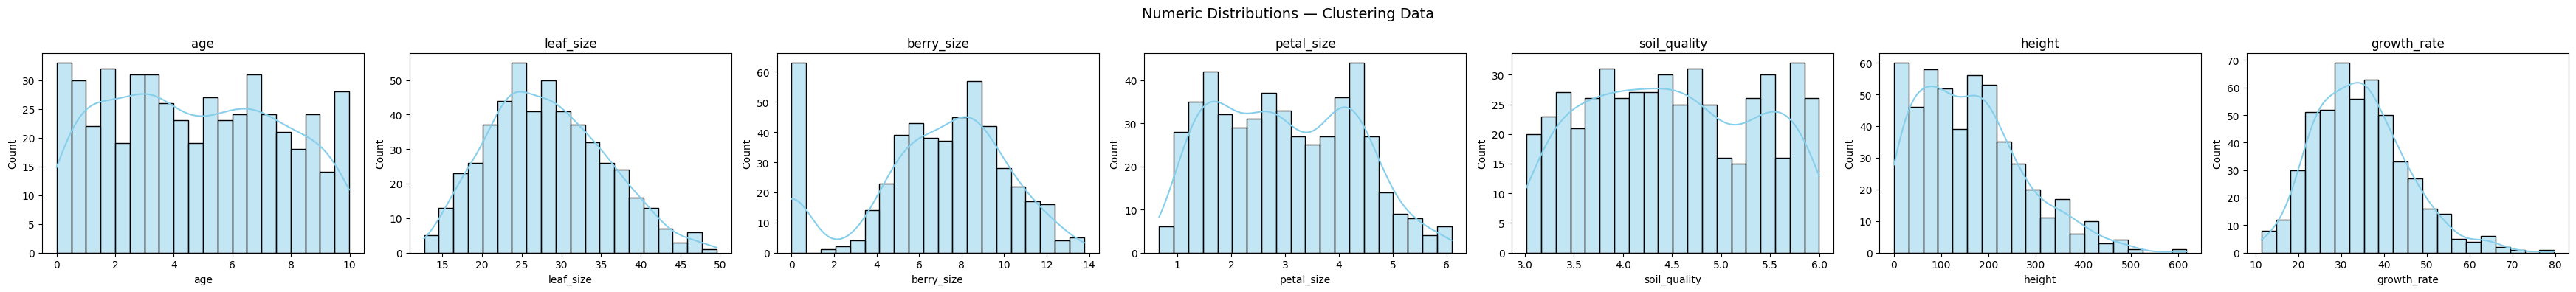

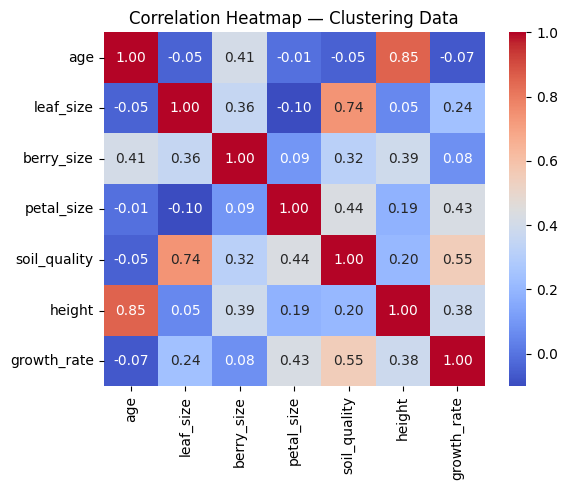

=== Edible Data ===
Shape: (500, 4)


,leaf_shape,petal_colour,berry_colour,edible
0,lanceolate,white,green,False
1,ovate,white,purple,False
2,lanceolate,white,blue,True
3,lanceolate,white,grey,False
4,ovate,pink,purple,True


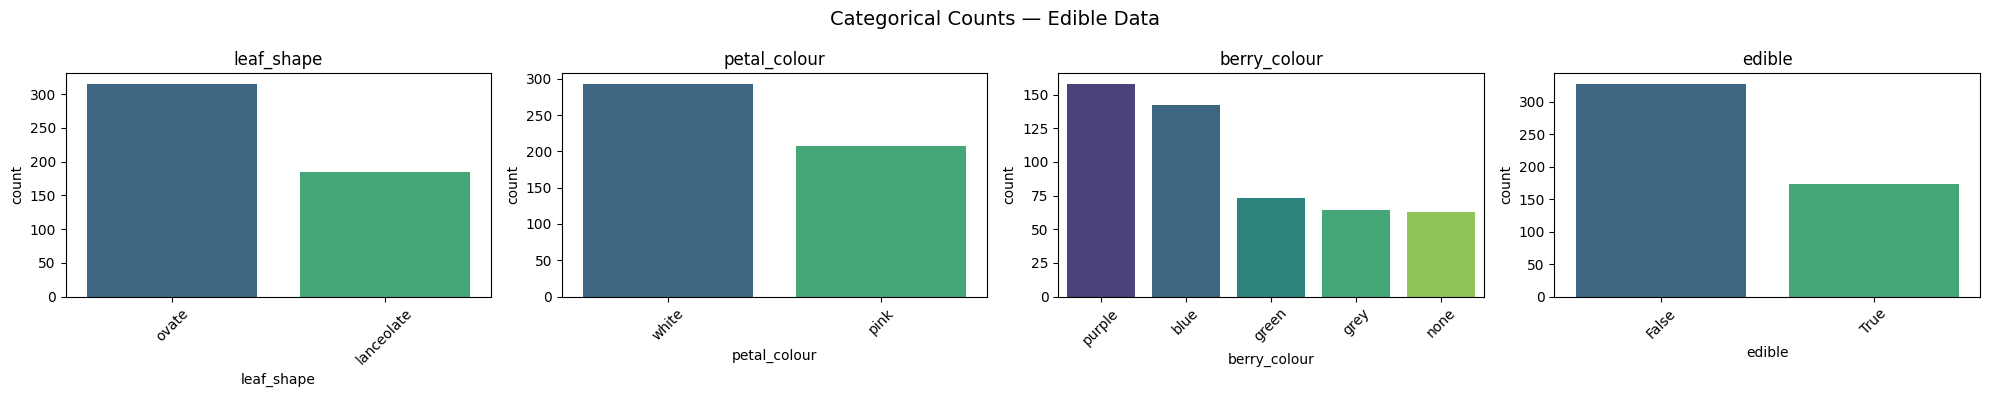

=== Species Data ===
Shape: (500, 4)


,leaf_shape,petal_colour,berry_colour,species
0,lanceolate,white,green,berrius actius
1,ovate,white,purple,berrius codiae
2,lanceolate,white,blue,berrius actius
3,lanceolate,white,grey,berrius elephas
4,ovate,pink,purple,berrius boethiae


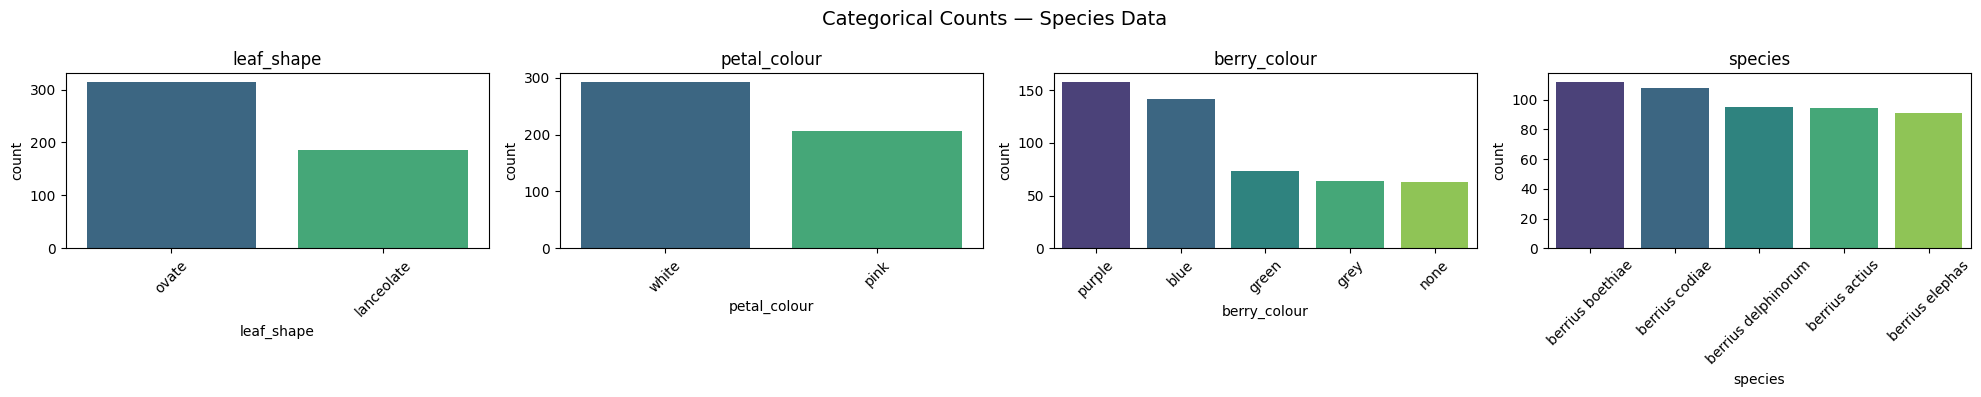

=== Berry_only Data ===
Shape: (500, 8)


,age,height,soil_quality,berry_colour,berry_size,edible,species,growth_rate
0,1.087322,50.725315,5.343953,green,10.085296,False,berrius actius,46.651592
1,8.416277,290.380659,4.371730,purple,6.695152,False,berrius codiae,34.502271
2,9.775323,408.956850,4.960159,blue,9.562278,True,berrius actius,41.835636
3,7.489012,228.010851,3.153180,grey,3.540497,False,berrius elephas,30.446052
4,8.390730,168.387228,3.224966,purple,7.130260,True,berrius boethiae,20.068246


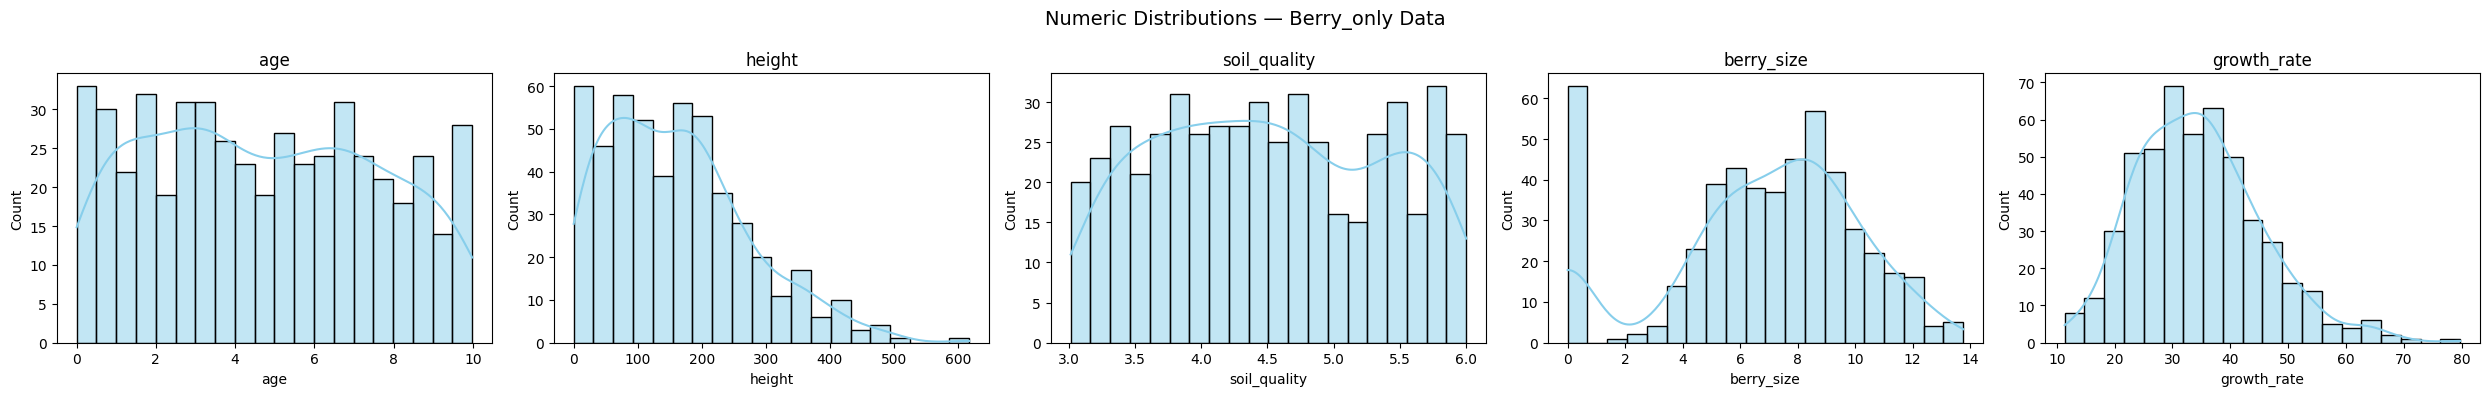

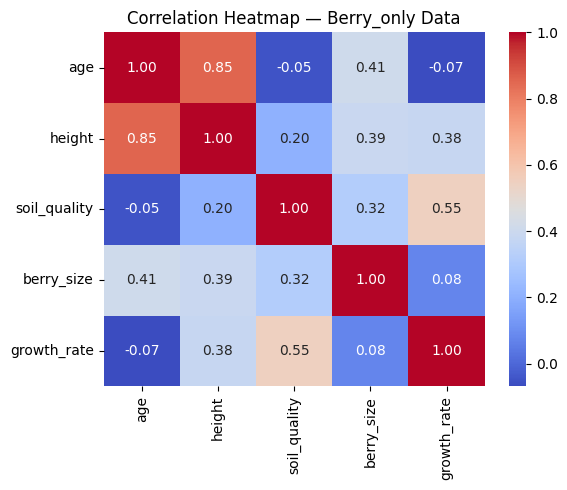

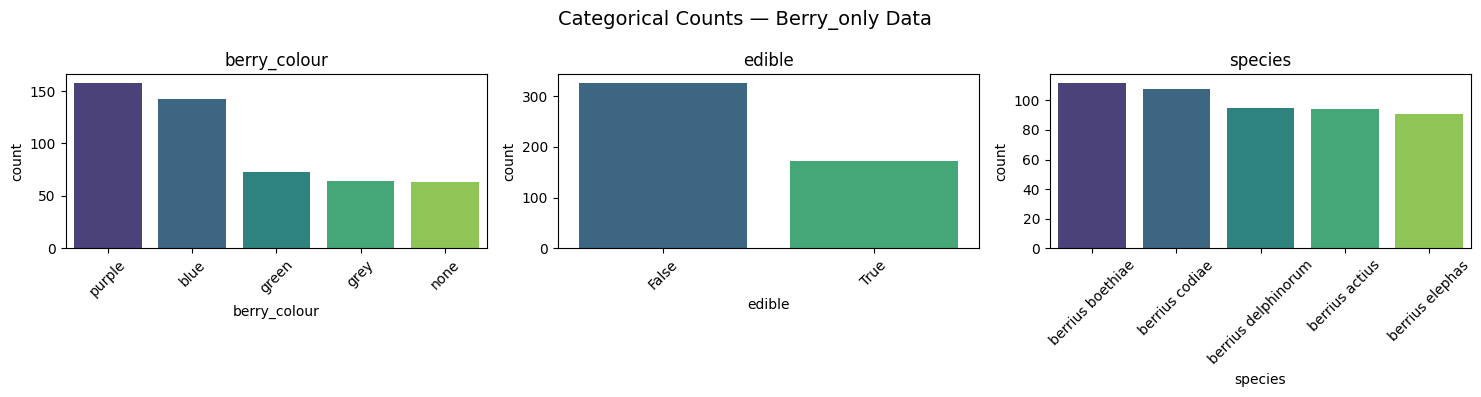

=== Leaf_only Data ===
Shape: (500, 8)


,age,height,soil_quality,leaf_shape,leaf_size,edible,species,growth_rate
0,1.087322,50.725315,5.343953,lanceolate,28.812701,False,berrius actius,46.651592
1,8.416277,290.380659,4.371730,ovate,31.325091,False,berrius codiae,34.502271
2,9.775323,408.956850,4.960159,lanceolate,22.536015,True,berrius actius,41.835636
3,7.489012,228.010851,3.153180,lanceolate,16.598960,False,berrius elephas,30.446052
4,8.390730,168.387228,3.224966,ovate,23.547034,True,berrius boethiae,20.068246


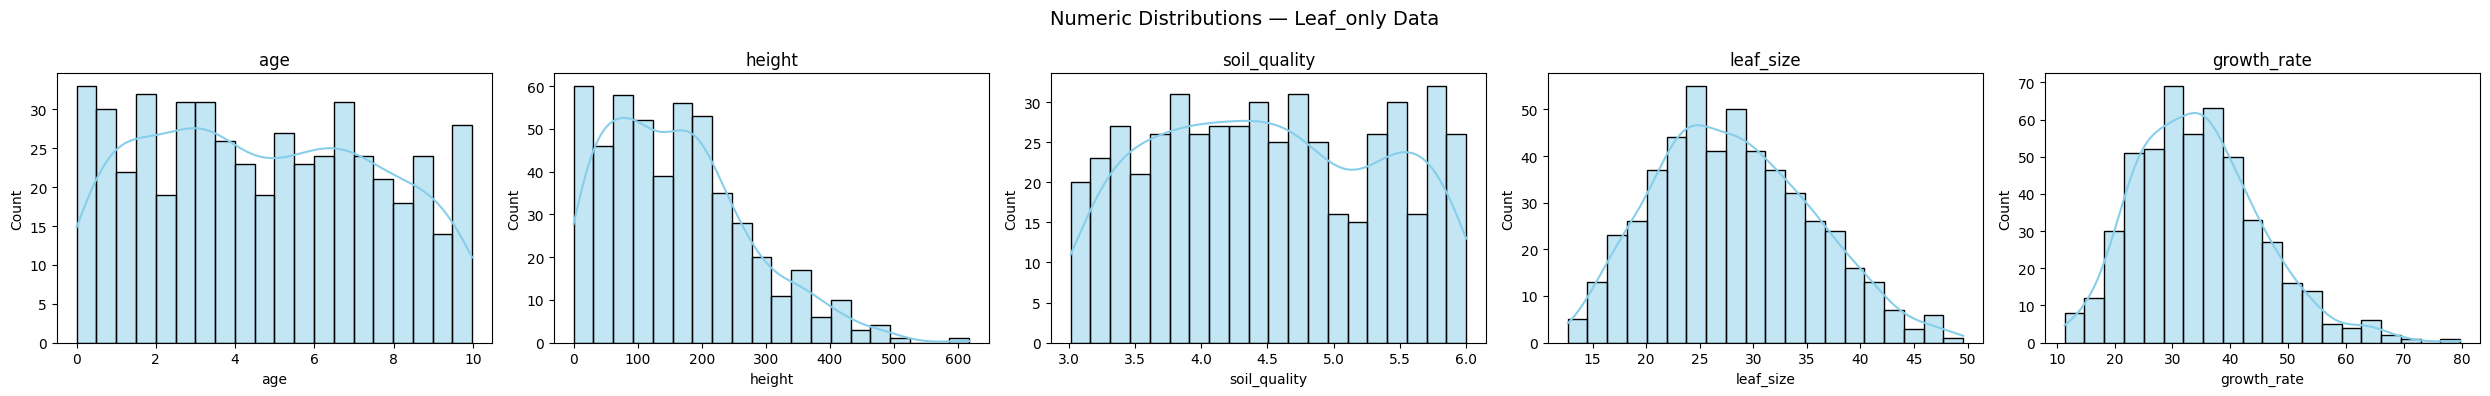

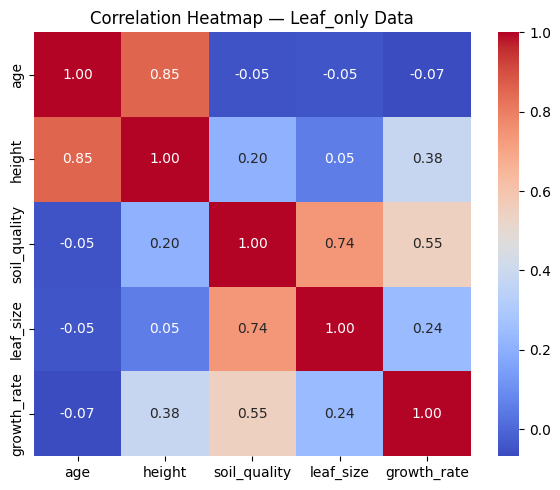

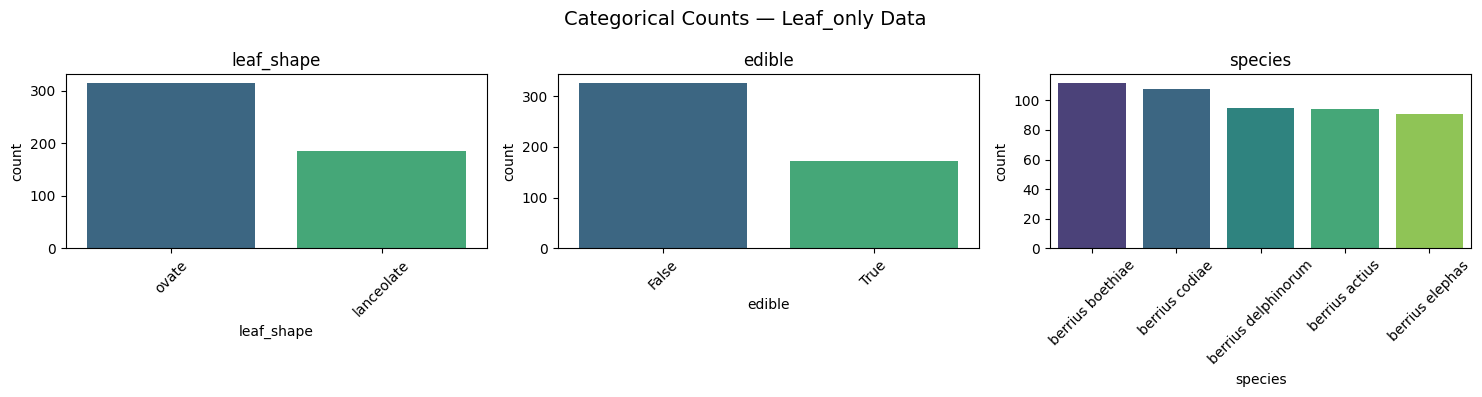

=== Petal_only Data ===
Shape: (500, 8)


,age,height,soil_quality,petal_colour,petal_size,edible,species,growth_rate
0,1.087322,50.725315,5.343953,white,4.517060,False,berrius actius,46.651592
1,8.416277,290.380659,4.371730,white,1.479155,False,berrius codiae,34.502271
2,9.775323,408.956850,4.960159,white,3.983370,True,berrius actius,41.835636
3,7.489012,228.010851,3.153180,white,3.117343,False,berrius elephas,30.446052
4,8.390730,168.387228,3.224966,pink,1.909403,True,berrius boethiae,20.068246


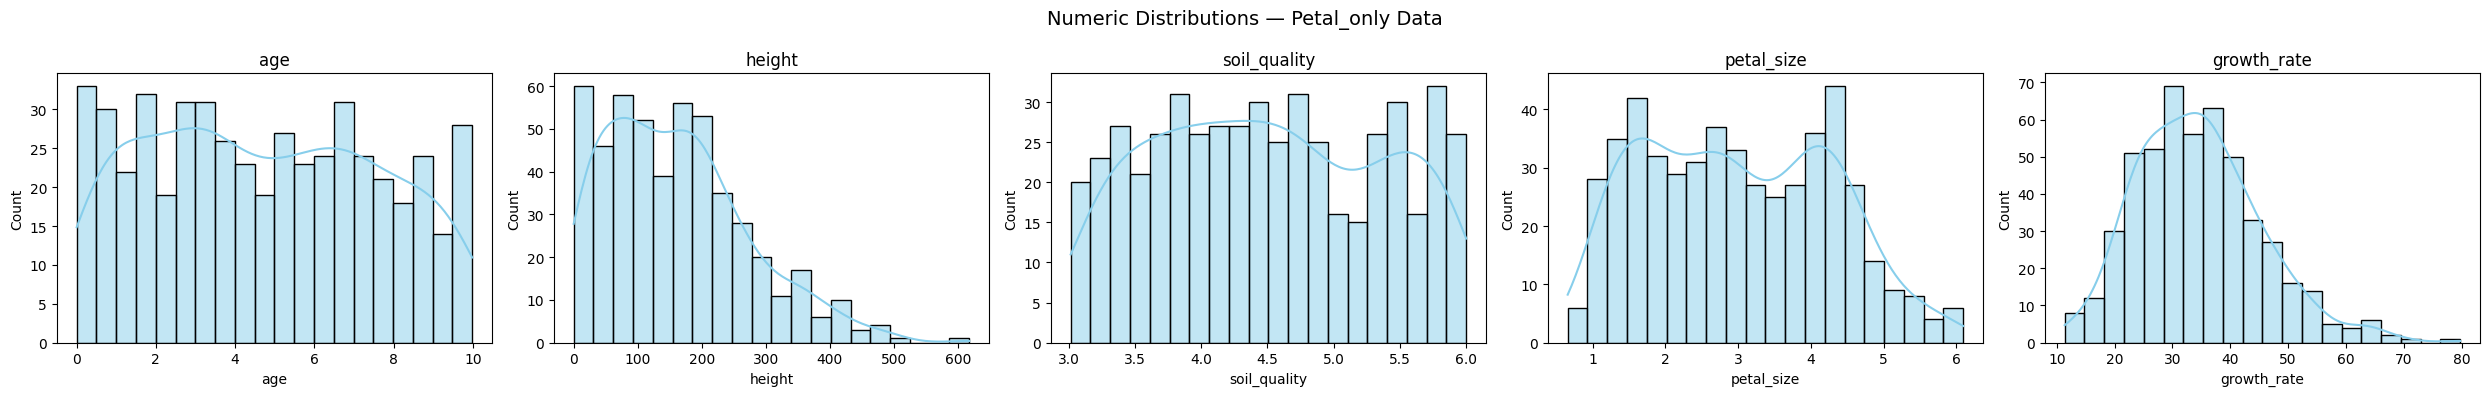

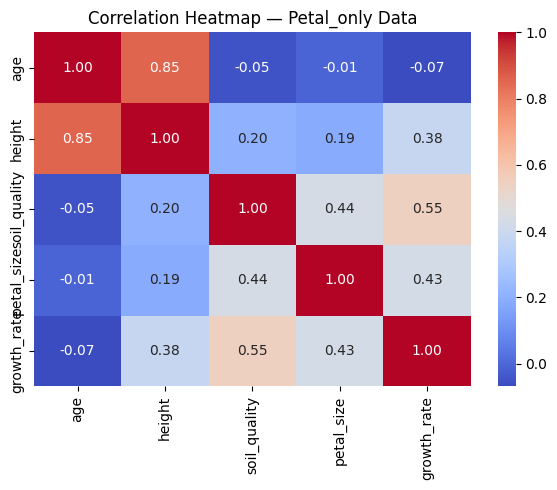

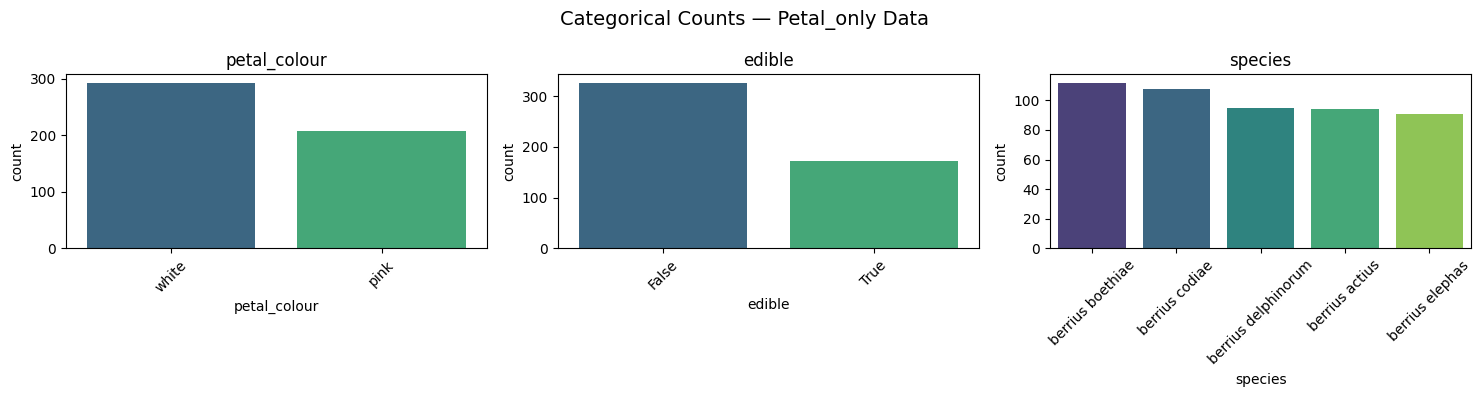

=== Complete Data ===
Shape: (500, 12)


,age,leaf_size,berry_colour,berry_size,leaf_shape,petal_colour,petal_size,height,edible,soil_quality,species,growth_rate
0,1.087322,28.812701,green,10.085296,lanceolate,white,4.517060,50.725315,False,5.343953,berrius actius,46.651592
1,8.416277,31.325091,purple,6.695152,ovate,white,1.479155,290.380659,False,4.371730,berrius codiae,34.502271
2,9.775323,22.536015,blue,9.562278,lanceolate,white,3.983370,408.956850,True,4.960159,berrius actius,41.835636
3,7.489012,16.598960,grey,3.540498,lanceolate,white,3.117343,228.010851,False,3.153180,berrius elephas,30.446052
4,8.390730,23.547034,purple,7.130260,ovate,pink,1.909403,168.387228,True,3.224966,berrius boethiae,20.068246


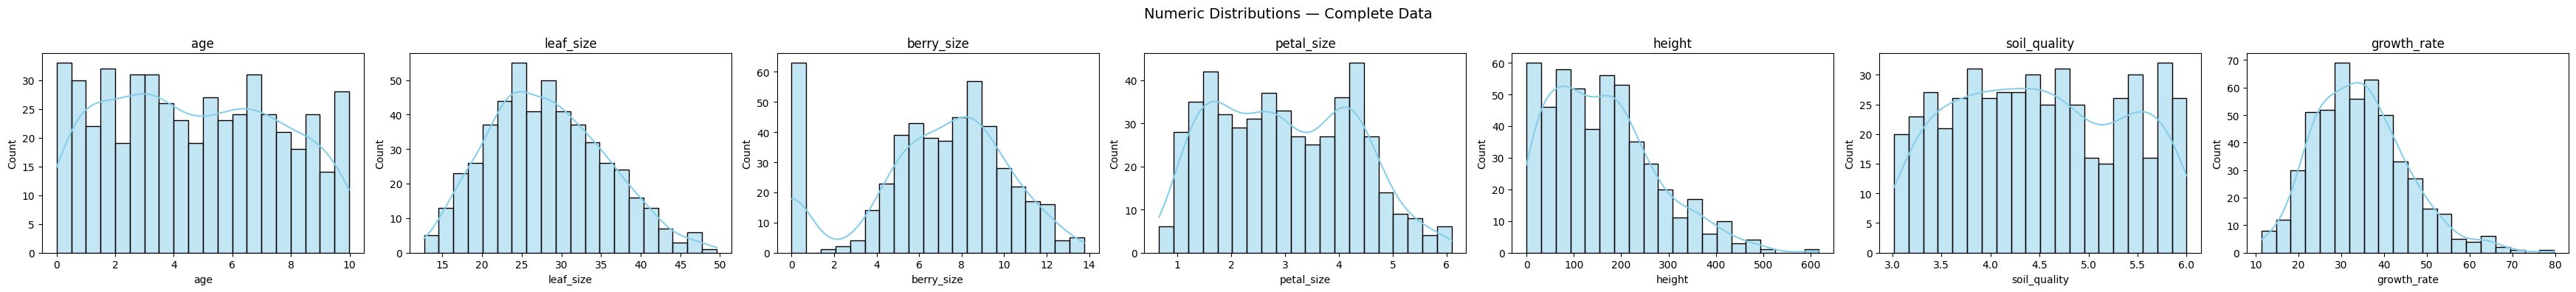

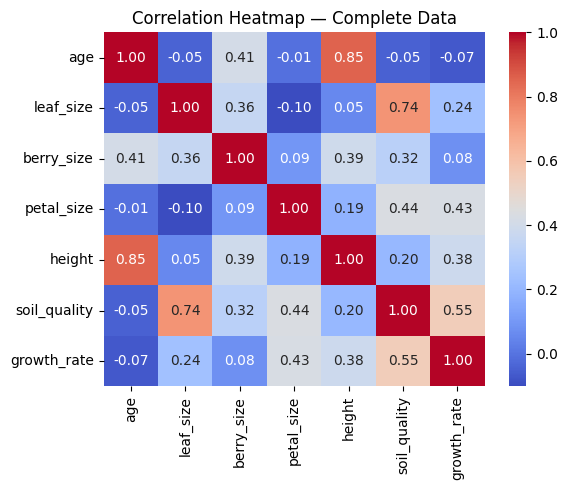

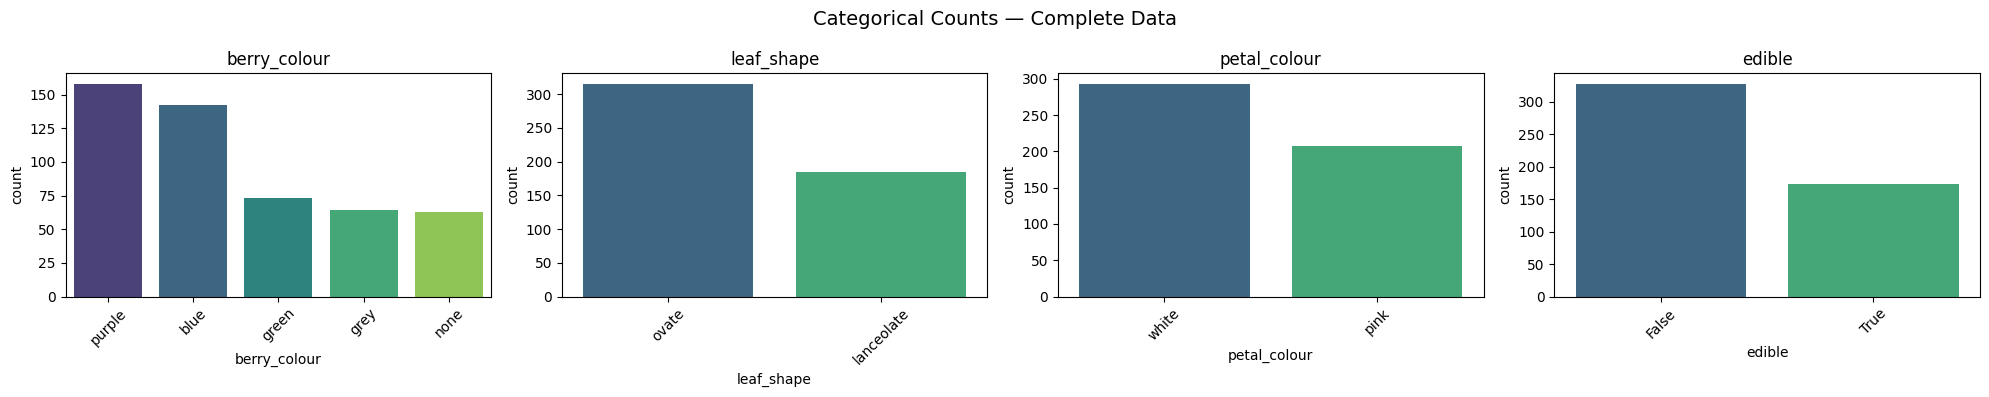

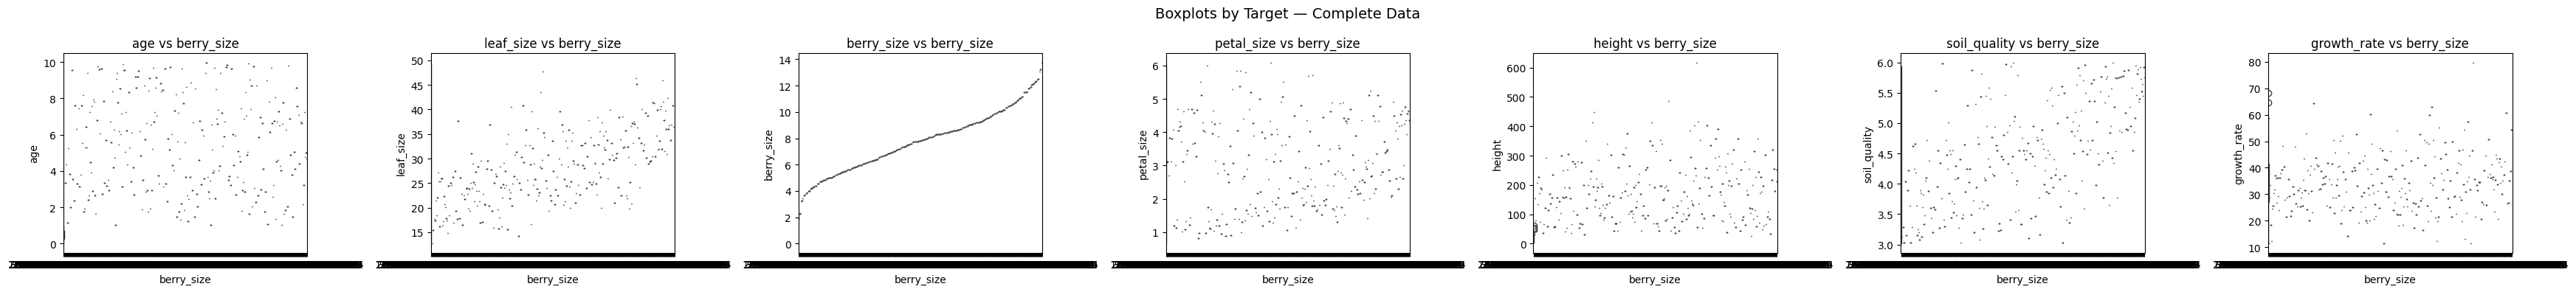

In [37]:
# --- Compact visualizations for all datasets ---
def visualize_dataset_compact(df, title="Dataset", target=None):
    print(f"=== {title} ===")
    print(f"Shape: {df.shape}")
    display(df.head())

    num_cols = df.select_dtypes(include="number").columns
    cat_cols = df.select_dtypes(exclude="number").columns

    # --- Numeric distributions ---
    if len(num_cols) > 0:
        n = len(num_cols)
        fig, axes = plt.subplots(1, n, figsize=(5*n, 4))
        if n == 1:  # single column case
            axes = [axes]
        for ax, col in zip(axes, num_cols):
            sns.histplot(df[col], bins=20, kde=True, ax=ax, color="skyblue")
            ax.set_title(f"{col}")
        fig.suptitle(f"Numeric Distributions — {title}", fontsize=14)
        plt.tight_layout()
        plt.show()

    # --- Correlation heatmap ---
    if len(num_cols) > 1:
        plt.figure(figsize=(6, 5))
        corr = df[num_cols].corr()
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
        plt.title(f"Correlation Heatmap — {title}")
        plt.tight_layout()
        plt.show()

    # --- Categorical counts (first 4 shown together) ---
    if len(cat_cols) > 0:
        n = min(len(cat_cols), 4)
        fig, axes = plt.subplots(1, n, figsize=(5*n, 4))
        if n == 1:
            axes = [axes]
        for ax, col in zip(axes, cat_cols[:n]):
            sns.countplot(x=df[col], order=df[col].value_counts().index[:10], ax=ax, palette="viridis")
            ax.set_title(col)
            ax.tick_params(axis="x", rotation=45)
        fig.suptitle(f"Categorical Counts — {title}", fontsize=14)
        plt.tight_layout()
        plt.show()

    # --- Boxplots vs target (if provided) ---
    if target and target in df.columns and len(num_cols) > 0:
        n = len(num_cols)
        fig, axes = plt.subplots(1, n, figsize=(5*n, 4))
        if n == 1:
            axes = [axes]
        for ax, col in zip(axes, num_cols):
            sns.boxplot(x=df[target], y=df[col], ax=ax)
            ax.set_title(f"{col} vs {target}")
        fig.suptitle(f"Boxplots by Target — {title}", fontsize=14)
        plt.tight_layout()
        plt.show()


# --- Loop through already loaded datasets in dfs ---
targets = {
    "clustering": None,
    "edible": "edible",
    "species": "species",
    "berry": "edible",
    "leaf": "edible",
    "petal": "edible",
    "complete": "berry_size"
}

for name, df in dfs.items():
    target = targets.get(name, None)
    visualize_dataset_compact(df, title=f"{name.capitalize()} Data", target=target)


## 3. Data Preparation

Imputation, encoding, scaling, derived features.

In [38]:
# --- Preprocessing pipelines ---
preprocessors = {}
for name, df in dfs.items():
    target_guess = None
    if name == "edible":
        target_guess = "edible"
    elif name == "species":
        target_guess = "species"
    elif name in ("berry_only","leaf_only","petal_only"):
        if "edible" in df.columns: target_guess = "edible"
        elif "species" in df.columns: target_guess = "species"
    elif name == "complete":
        if "berry_size" in df.columns: target_guess = "berry_size"
    num_cols, cat_cols = auto_feature_types(df, target=target_guess)
    print(f"\n{name}: target={target_guess}, numeric={num_cols}, categorical={cat_cols}")
    pre, n, c = make_preprocessor(df, target=target_guess)
    preprocessors[name] = (pre, n, c, target_guess)



clustering: target=None, numeric=['age', 'leaf_size', 'berry_size', 'petal_size', 'soil_quality', 'height', 'growth_rate'], categorical=[]

edible: target=edible, numeric=[], categorical=['leaf_shape', 'petal_colour', 'berry_colour']

species: target=species, numeric=[], categorical=['leaf_shape', 'petal_colour', 'berry_colour']

berry_only: target=edible, numeric=['age', 'height', 'soil_quality', 'berry_size', 'growth_rate'], categorical=['berry_colour', 'species']

leaf_only: target=edible, numeric=['age', 'height', 'soil_quality', 'leaf_size', 'growth_rate'], categorical=['leaf_shape', 'species']

petal_only: target=edible, numeric=['age', 'height', 'soil_quality', 'petal_size', 'growth_rate'], categorical=['petal_colour', 'species']

complete: target=berry_size, numeric=['age', 'leaf_size', 'petal_size', 'height', 'soil_quality', 'growth_rate'], categorical=['berry_colour', 'leaf_shape', 'petal_colour', 'edible', 'species']


## 4.1 Clustering (clustering.json)

Compare KMeans, Agglomerative, DBSCAN, GMM; try derived features.

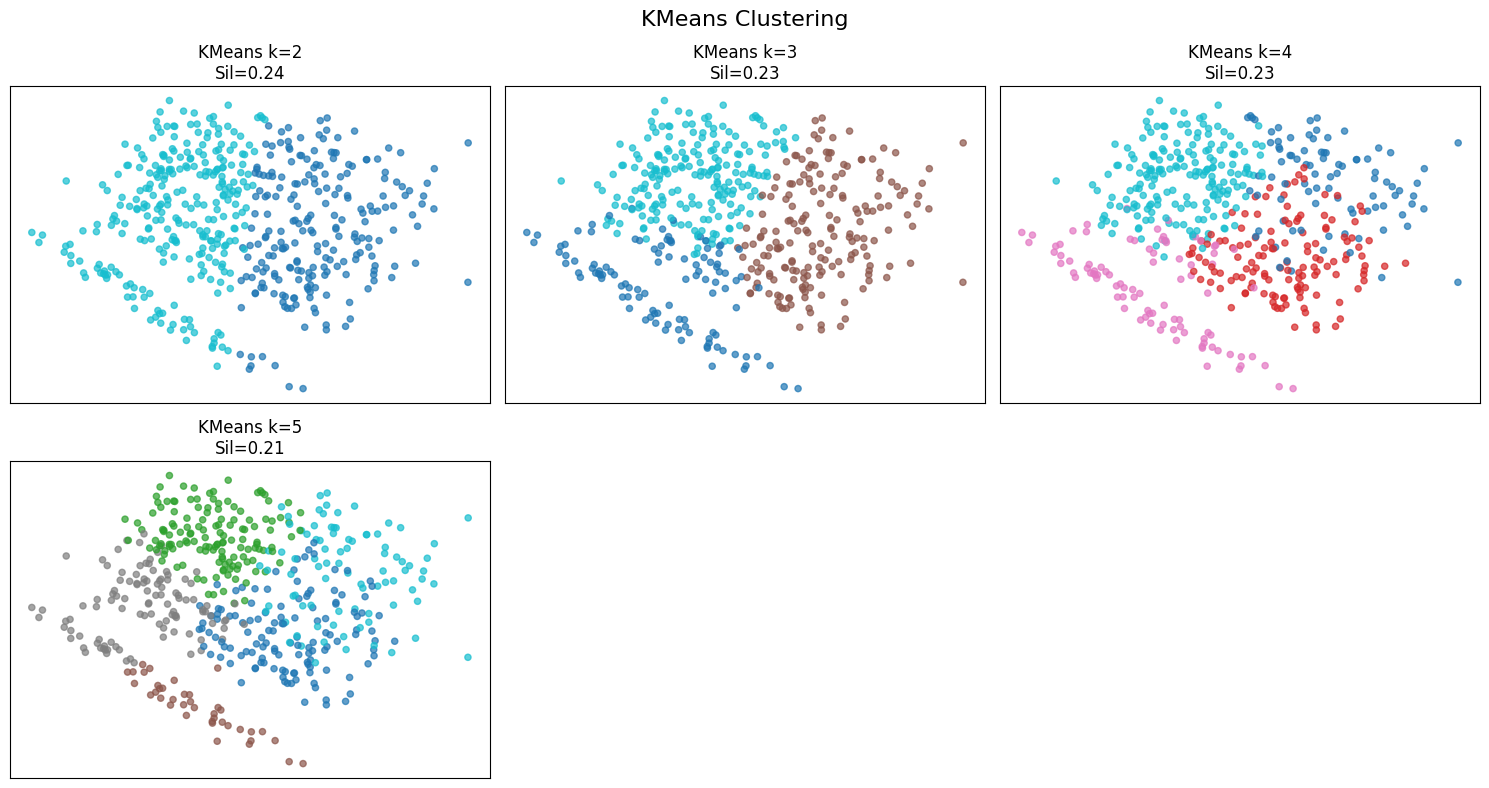

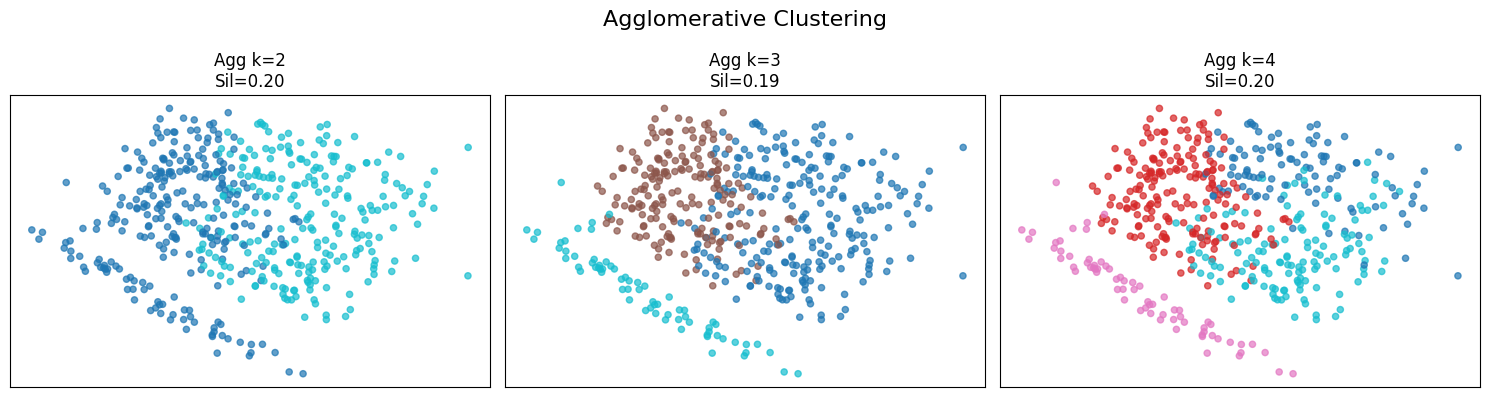

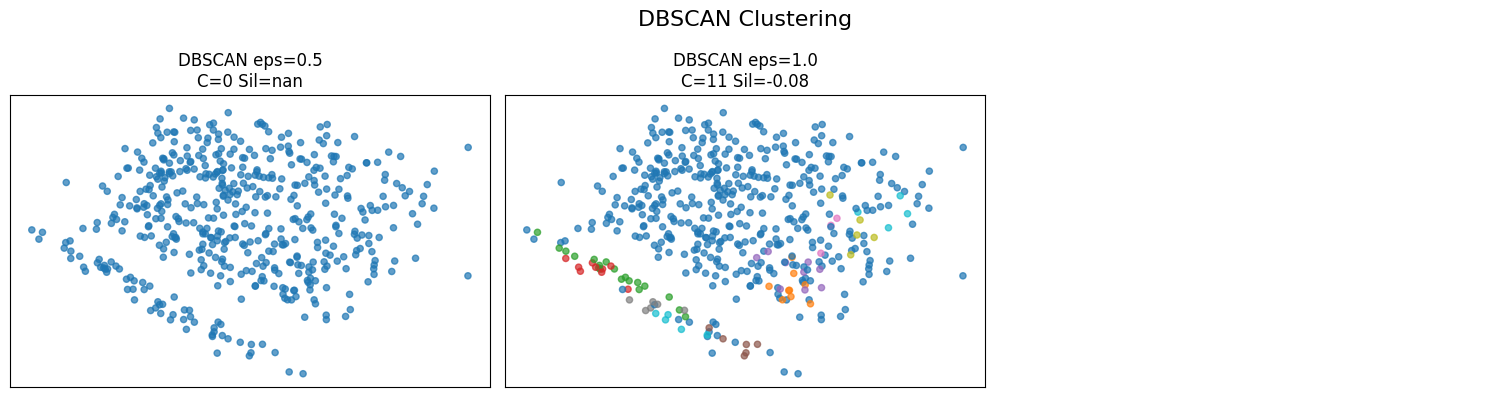

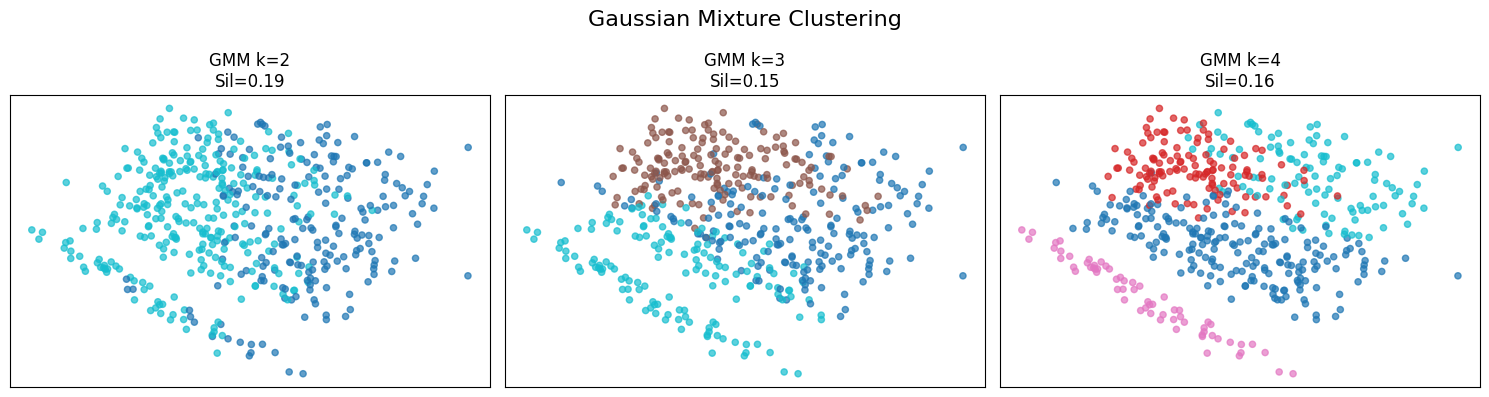

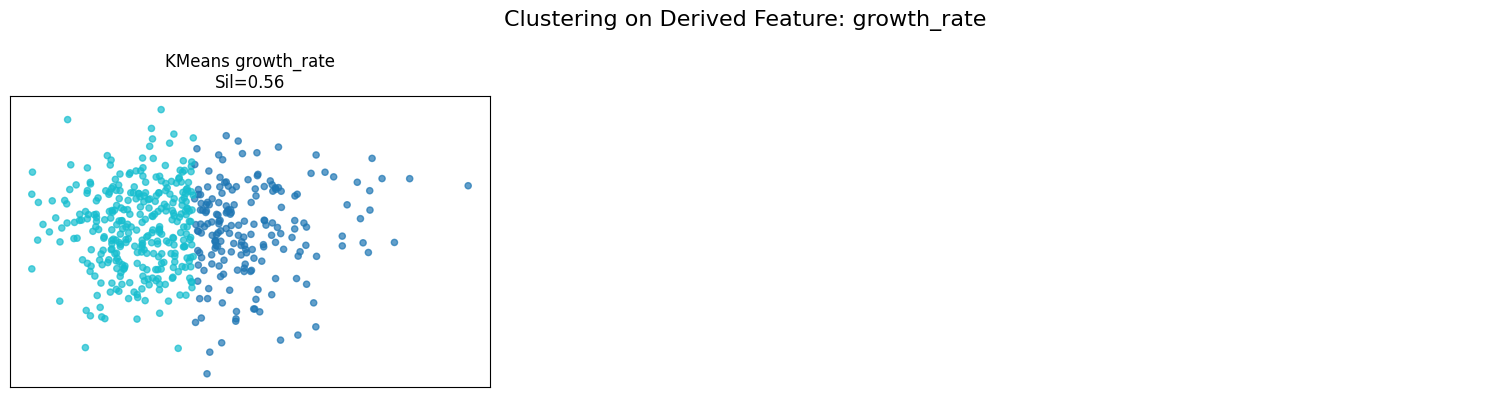

In [39]:
# --- Clustering analysis on clustering.json ---
def visualize_clusters_grid(X, clusterings, title="Cluster Comparison", ncols=3):
    """Show multiple clustering results in a subplot grid.
       Handles 1D (no PCA) and 2D+ (with PCA)."""
    n = len(clusterings)
    nrows = int(np.ceil(n / ncols))

    if X.shape[1] > 1:
        pca = PCA(n_components=2, random_state=42)
        X2d = pca.fit_transform(X)
        xvals, yvals = X2d[:,0], X2d[:,1]
    else:
        xvals = X[:,0]
        # jitter y a little so points don’t overlap
        yvals = np.random.normal(0, 0.01, size=len(xvals))

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten()

    for i, (labels, subtitle) in enumerate(clusterings):
        ax = axes[i]
        scatter = ax.scatter(xvals, yvals, c=labels, cmap="tab10", s=20, alpha=0.7)
        ax.set_title(subtitle)
        ax.set_xticks([])
        ax.set_yticks([])
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


if "clustering" in dfs:
    dfc = dfs["clustering"].copy()
    num_cols = dfc.select_dtypes(include=np.number).columns.tolist()
    if not num_cols:
        raise ValueError("No numeric features found for clustering.")

    # preprocess
    X = dfc[num_cols].copy().replace([np.inf,-np.inf], np.nan)
    imputer = SimpleImputer(strategy="median")
    scaler = StandardScaler()
    Xp = scaler.fit_transform(imputer.fit_transform(X))

    # --- KMeans ---
    clusterings = []
    for k in [2, 3, 4, 5]:
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels = km.fit_predict(Xp)
        score = silhouette_score(Xp, labels)
        clusterings.append((labels, f"KMeans k={k}\nSil={score:.2f}"))
    visualize_clusters_grid(Xp, clusterings, title="KMeans Clustering")

    # --- Agglomerative ---
    clusterings = []
    for k in [2, 3, 4]:
        agg = AgglomerativeClustering(n_clusters=k)
        labels = agg.fit_predict(Xp)
        score = silhouette_score(Xp, labels) if len(set(labels))>1 else np.nan
        clusterings.append((labels, f"Agg k={k}\nSil={score:.2f}"))
    visualize_clusters_grid(Xp, clusterings, title="Agglomerative Clustering")

    # --- DBSCAN ---
    clusterings = []
    for eps in [0.5, 1.0]:
        db = DBSCAN(eps=eps, min_samples=5)
        labels = db.fit_predict(Xp)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        score = silhouette_score(Xp, labels) if n_clusters>1 else np.nan
        clusterings.append((labels, f"DBSCAN eps={eps}\nC={n_clusters} Sil={score:.2f}"))
    visualize_clusters_grid(Xp, clusterings, title="DBSCAN Clustering")

    # --- GMM ---
    clusterings = []
    for k in [2, 3, 4]:
        gmm = GaussianMixture(n_components=k, random_state=42)
        labels = gmm.fit_predict(Xp)
        score = silhouette_score(Xp, labels) if len(set(labels))>1 else np.nan
        clusterings.append((labels, f"GMM k={k}\nSil={score:.2f}"))
    visualize_clusters_grid(Xp, clusterings, title="Gaussian Mixture Clustering")

    # --- Growth rate only (derived variable) ---
    if "growth_rate" in dfc.columns:
        Xg = dfc[["growth_rate"]].copy()
        Xg = scaler.fit_transform(imputer.fit_transform(Xg))
        km = KMeans(n_clusters=2, n_init=10, random_state=42)
        labels = km.fit_predict(Xg)
        score = silhouette_score(Xg, labels)
        visualize_clusters_grid(
            Xg,
            [(labels, f"KMeans growth_rate\nSil={score:.2f}")],
            title="Clustering on Derived Feature: growth_rate"
        )


## 4.2 Edibility rules (edible.json)

Decision Tree rules, RandomForest baseline, Logistic Regression.

DecisionTree performance:
              precision    recall  f1-score   support

       False       1.00      0.89      0.94        65
        True       0.83      1.00      0.91        35

    accuracy                           0.93       100
   macro avg       0.92      0.95      0.93       100
weighted avg       0.94      0.93      0.93       100


Readable rules (DecisionTree):

|--- berry_colour_green <= 0.50
|   |--- berry_colour_grey <= 0.50
|   |   |--- leaf_shape_lanceolate <= 0.50
|   |   |   |--- petal_colour_white <= 0.50
|   |   |   |   |--- berry_colour_blue <= 0.50
|   |   |   |   |   |--- class: True
|   |   |   |   |--- berry_colour_blue >  0.50
|   |   |   |   |   |--- class: False
|   |   |   |--- petal_colour_white >  0.50
|   |   |   |   |--- class: False
|   |   |--- leaf_shape_lanceolate >  0.50
|   |   |   |--- berry_colour_none <= 0.50
|   |   |   |   |--- class: True
|   |   |   |--- berry_colour_none >  0.50
|   |   |   |   |--- class: True
|   |--- berry_col

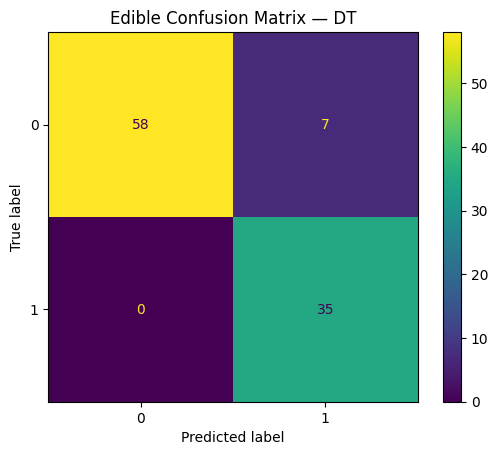

In [40]:

if "edible" in dfs:
    dfe = dfs["edible"].copy()
    assert "edible" in dfe.columns, "Expected `edible` target"
    y = dfe["edible"]
    X = dfe.drop(columns=["edible"])

    pre, num_cols, cat_cols = make_preprocessor(dfe, target="edible", scale_numeric=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    tree = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight="balanced")
    pipe_tree = Pipeline([("pre", pre), ("model", tree)])
    pipe_tree.fit(X_train, y_train)
    y_pred = pipe_tree.predict(X_test)
    print("DecisionTree performance:")
    print(classification_report(y_test, y_pred))

    enc_pre = pre
    enc_pre.fit(X_train)
    Xt = enc_pre.transform(X_train)
    num_cols2 = enc_pre.transformers_[0][2]
    cat_enc = enc_pre.transformers_[1][1]["onehot"]
    cat_cols2 = enc_pre.transformers_[1][2]
    feat_names = list(num_cols2) + list(cat_enc.get_feature_names_out(cat_cols2))
    tree2 = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight="balanced")
    tree2.fit(Xt, y_train)
    print("\nReadable rules (DecisionTree):\n")
    print(export_text(tree2, feature_names=list(feat_names)))

    rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced")
    pipe_rf = Pipeline([("pre", pre), ("model", rf)])
    pipe_rf.fit(X_train, y_train)
    y_pred_rf = pipe_rf.predict(X_test)
    print("RandomForest performance:")
    print(classification_report(y_test, y_pred_rf))

    lr = LogisticRegression(max_iter=2000, class_weight="balanced")
    pipe_lr = Pipeline([("pre", pre), ("model", lr)])
    pipe_lr.fit(X_train, y_train)
    y_pred_lr = pipe_lr.predict(X_test)
    print("LogisticRegression performance:")
    print(classification_report(y_test, y_pred_lr))

    scores = {
        "DT": f1_score(y_test, y_pred, average="weighted"),
        "RF": f1_score(y_test, y_pred_rf, average="weighted"),
        "LR": f1_score(y_test, y_pred_lr, average="weighted"),
    }
    best = max(scores, key=scores.get)
    best_pred = {"DT": y_pred, "RF": y_pred_rf, "LR": y_pred_lr}[best]
    print(f"Best by weighted F1: {best}")
    cm = confusion_matrix(y_test, best_pred)
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots()
    disp.plot(ax=ax)
    plt.title(f"Edible Confusion Matrix — {best}")
    plt.show()


## 4.3 Species classification (species.json)

Multi-class baselines and confusion matrix.

DecisionTree: accuracy=0.8900 | F1_weighted=0.8875
RandomForest: accuracy=0.8900 | F1_weighted=0.8875
LogReg: accuracy=0.8900 | F1_weighted=0.8875
Best by weighted F1: DecisionTree


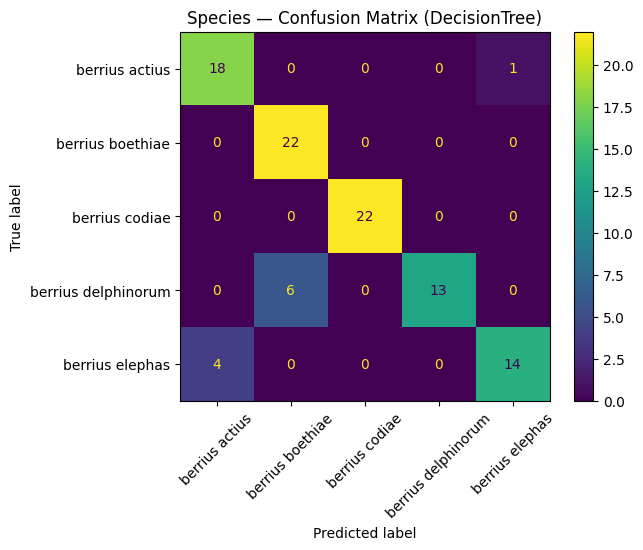

In [41]:

if "species" in dfs:
    dfspec = dfs["species"].copy()
    assert "species" in dfspec.columns, "Expected `species` target"
    y = dfspec["species"]
    X = dfspec.drop(columns=["species"])

    pre, num_cols, cat_cols = make_preprocessor(dfspec, target="species", scale_numeric=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    models = {
        "DecisionTree": DecisionTreeClassifier(max_depth=6, random_state=42, class_weight="balanced"),
        "RandomForest": RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced"),
        "LogReg": LogisticRegression(max_iter=2000, multi_class="auto", class_weight="balanced"),
    }
    results = {}
    for name, model in models.items():
        pipe = Pipeline([("pre", pre), ("model", model)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1w = f1_score(y_test, y_pred, average="weighted")
        results[name] = (acc, f1w, y_pred)
        print(f"{name}: accuracy={acc:.4f} | F1_weighted={f1w:.4f}")
    best = max(results.items(), key=lambda kv: kv[1][1])[0]
    print(f"Best by weighted F1: {best}")
    cm = confusion_matrix(y_test, results[best][2], labels=np.unique(y_test))
    disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test))
    fig, ax = plt.subplots()
    disp.plot(ax=ax, xticks_rotation=45)
    plt.title(f"Species — Confusion Matrix ({best})")
    plt.show()


## 4.4 Single-modality vs pipeline (berry.json / leaf.json / petal.json)

Compare direct edible vs species→edible mapping.

In [42]:

def learn_species_to_edible_mapping(edible_df, species_df=None):
    mapping = {}
    frames = []
    if edible_df is not None and {"species","edible"}.issubset(edible_df.columns):
        frames.append(edible_df[["species","edible"]].dropna())
    if species_df is not None and {"species","edible"}.issubset(species_df.columns):
        frames.append(species_df[["species","edible"]].dropna())
    if frames:
        cat = pd.concat(frames, axis=0, ignore_index=True)
        gr = cat.groupby("species")["edible"].agg(lambda s: s.value_counts().idxmax())
        mapping = gr.to_dict()
    return mapping

species_to_edible = learn_species_to_edible_mapping(dfs.get("edible"), dfs.get("species"))

def direct_edible_baseline(df, name):
    if "edible" not in df.columns:
        print(f"[{name}] No 'edible' target; skipping.")
        return None
    X = df.drop(columns=["edible"])
    y = df["edible"]
    pre, *_ = make_preprocessor(df, target="edible", scale_numeric=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    pipe = Pipeline([("pre", pre), ("model", RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced'))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average="weighted")
    print(f"[{name}] Direct edible: accuracy={acc:.4f} | F1w={f1w:.4f}")
    return acc, f1w

def pipeline_species_then_edible(df, name):
    if "species" not in df.columns or not species_to_edible:
        print(f"[{name}] Cannot run species→edible pipeline (need species column and mapping).")
        return None
    y_species = df["species"]
    X = df.drop(columns=["species"])
    pre, *_ = make_preprocessor(df, target="species", scale_numeric=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y_species, test_size=0.25, random_state=42, stratify=y_species)
    pipe_species = Pipeline([("pre", pre), ("model", RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced'))])
    pipe_species.fit(X_train, y_train)
    y_species_pred = pipe_species.predict(X_test)

    y_edible_pred = pd.Series(y_species_pred).map(species_to_edible).values
    if "edible" in df.columns:
        y_true = df.loc[y_test.index, "edible"].values
        mask = pd.notna(y_edible_pred)
        acc = accuracy_score(y_true[mask], y_edible_pred[mask])
        f1w = f1_score(y_true[mask], y_edible_pred[mask], average="weighted")
        print(f"[{name}] Pipeline species→edible: accuracy={acc:.4f} | F1w={f1w:.4f}")
        return acc, f1w
    else:
        print(f"[{name}] Produced edible predictions via pipeline (no ground truth edible).")
        return None

for key, name in [("berry_only","Berries-only"), ("leaf_only","Leaves-only"), ("petal_only","Petals-only")]:
    if key in dfs:
        df = dfs[key].copy()
        print(f"\n=== {name} ===")
        direct_edible_baseline(df, name)
        pipeline_species_then_edible(df, name)



=== Berries-only ===
[Berries-only] Direct edible: accuracy=1.0000 | F1w=1.0000
[Berries-only] Cannot run species→edible pipeline (need species column and mapping).

=== Leaves-only ===
[Leaves-only] Direct edible: accuracy=0.9920 | F1w=0.9920
[Leaves-only] Cannot run species→edible pipeline (need species column and mapping).

=== Petals-only ===
[Petals-only] Direct edible: accuracy=0.9920 | F1w=0.9920
[Petals-only] Cannot run species→edible pipeline (need species column and mapping).


## 4.5 Berry size regression (complete.json)

All plants vs edible-only; explicit linear formula; without soil_quality if present.

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def print_regression_report(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # compatible with all sklearn versions
    r2 = r2_score(y_true, y_pred)
    print(f"{label}: MAE={mae:.4f} | RMSE={rmse:.4f} | R^2={r2:.4f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


def run_regression_experiment(df, label="All plants", drop_features=None):
    assert "berry_size" in df.columns, "Expected `berry_size` in complete.json"
    drop_features = drop_features or []
    y = df["berry_size"].astype(float)
    X = df.drop(columns=["berry_size"] + drop_features)

    pre, *_ = make_preprocessor(pd.concat([X, y], axis=1), target="berry_size", scale_numeric=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    models = {
        "Linear": LinearRegression(),
        "Ridge": Ridge(alpha=1.0),
        "RF": RandomForestRegressor(n_estimators=400, random_state=42),
    }
    reports = {}
    for name, model in models.items():
        pipe = Pipeline([("pre", pre), ("model", model)])
        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)
        rep = print_regression_report(y_test, pred, label=f"{label} — {name}")
        reports[name] = (pipe, rep)

    lin_pipe = reports["Linear"][0]
    enc = lin_pipe.named_steps["pre"]
    lin = lin_pipe.named_steps["model"]
    enc.fit(X_train)
    num_cols2 = enc.transformers_[0][2]
    cat_enc = enc.transformers_[1][1]["onehot"]
    cat_cols2 = enc.transformers_[1][2]
    feat_names = list(num_cols2) + list(cat_enc.get_feature_names_out(cat_cols2))
    coefs = lin.coef_.ravel()
    intercept = float(lin.intercept_)
    print("\nExplicit Linear Model (encoded/scaled features):")
    print("berry_size ≈ " + str(round(intercept,6)) + " + " + " + ".join([f"({round(float(c),6)})*{n}" for n,c in zip(feat_names, coefs)]))
    return reports


# --- Run experiments ---
if "complete" in dfs:
    dfc = dfs["complete"].copy()

    print("## All plants")
    rep_all = run_regression_experiment(dfc, label="All plants")

    if "edible" in dfc.columns:
        print("\n## Edible subset only")
        rep_edible = run_regression_experiment(dfc[dfc["edible"]==1], label="Edible only")

    drop_soil = ["soil_quality"] if "soil_quality" in dfc.columns else []
    if drop_soil:
        print("\n## All plants — without soil_quality")
        rep_all_nosoil = run_regression_experiment(dfc, label="All plants (no soil_quality)", drop_features=drop_soil)


## All plants
All plants — Linear: MAE=0.9567 | RMSE=1.1687 | R^2=0.8584
All plants — Ridge: MAE=0.9526 | RMSE=1.1622 | R^2=0.8599
All plants — RF: MAE=0.8371 | RMSE=1.0709 | R^2=0.8811

Explicit Linear Model (encoded/scaled features):
berry_size ≈ 5.945744 + (0.167194)*age + (-0.119296)*leaf_size + (-0.366948)*petal_size + (-0.176307)*height + (1.3121)*soil_quality + (-0.038144)*growth_rate + (2.597034)*berry_colour_blue + (1.22608)*berry_colour_green + (0.467373)*berry_colour_grey + (-6.123288)*berry_colour_none + (1.832801)*berry_colour_purple + (0.167757)*leaf_shape_lanceolate + (-0.167757)*leaf_shape_ovate + (0.840181)*petal_colour_pink + (-0.840181)*petal_colour_white + (0.713153)*edible_False + (-0.713153)*edible_True + (0.799517)*species_berrius actius + (0.603533)*species_berrius boethiae + (-1.007939)*species_berrius codiae + (0.236648)*species_berrius delphinorum + (-0.631759)*species_berrius elephas

## Edible subset only
Edible only — Linear: MAE=0.9158 | RMSE=1.1427 | R^2

## 5. Evaluation

Summarize clustering quality, edibility/species performance, and regression metrics.

## 6. Deployment (Lightweight)

Export fitted edible and size pipelines for quick reuse.

In [48]:

import joblib
from pathlib import Path

model_dir = Path("../model")
model_dir.mkdir(exist_ok=True)

try:
    if "edible" in dfs:
        dfe = dfs["edible"].copy()
        y = dfe["edible"]
        X = dfe.drop(columns=["edible"])
        pre, *_ = make_preprocessor(dfe, target="edible", scale_numeric=True)
        pipe_rf = Pipeline([("pre", pre), ("model", RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced'))])
        pipe_rf.fit(X, y)
        joblib.dump(pipe_rf, model_dir / "model_edible_rf.joblib")
        print("Saved:", model_dir / "model_edible_rf.joblib")
except Exception as e:
    print(f"[WARN] Could not train/save edible model: {e}")

try:
    if "complete" in dfs:
        dfc = dfs["complete"].copy()
        y = dfc["berry_size"].astype(float)
        X = dfc.drop(columns=["berry_size"])
        pre, *_ = make_preprocessor(pd.concat([X, y], axis=1), target="berry_size", scale_numeric=True)
        pipe_ridge = Pipeline([("pre", pre), ("model", Ridge(alpha=1.0))])
        pipe_ridge.fit(X, y)
        joblib.dump(pipe_ridge, model_dir / "model_berrysize_ridge.joblib")
        print("Saved:", model_dir / "model_berrysize_ridge.joblib")
except Exception as e:
    print(f"[WARN] Could not train/save berry-size model: {e}")

def predict_edible(example: dict):
    import joblib, pandas as pd
    pipe = joblib.load("model/model_edible_rf.joblib")
    X = pd.DataFrame([example])
    return pipe.predict(X)[0]

def predict_size(example: dict):
    import joblib, pandas as pd
    pipe = joblib.load("model/model_berrysize_ridge.joblib")
    X = pd.DataFrame([example])
    return float(pipe.predict(X)[0])


Saved: ../model/model_edible_rf.joblib
Saved: ../model/model_berrysize_ridge.joblib
